In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

filename='/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv'
df=pd.read_csv(filename)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv


In [49]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [50]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [51]:
X=df.loc[ : , df.columns != 'quality'].values
y=df['quality'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


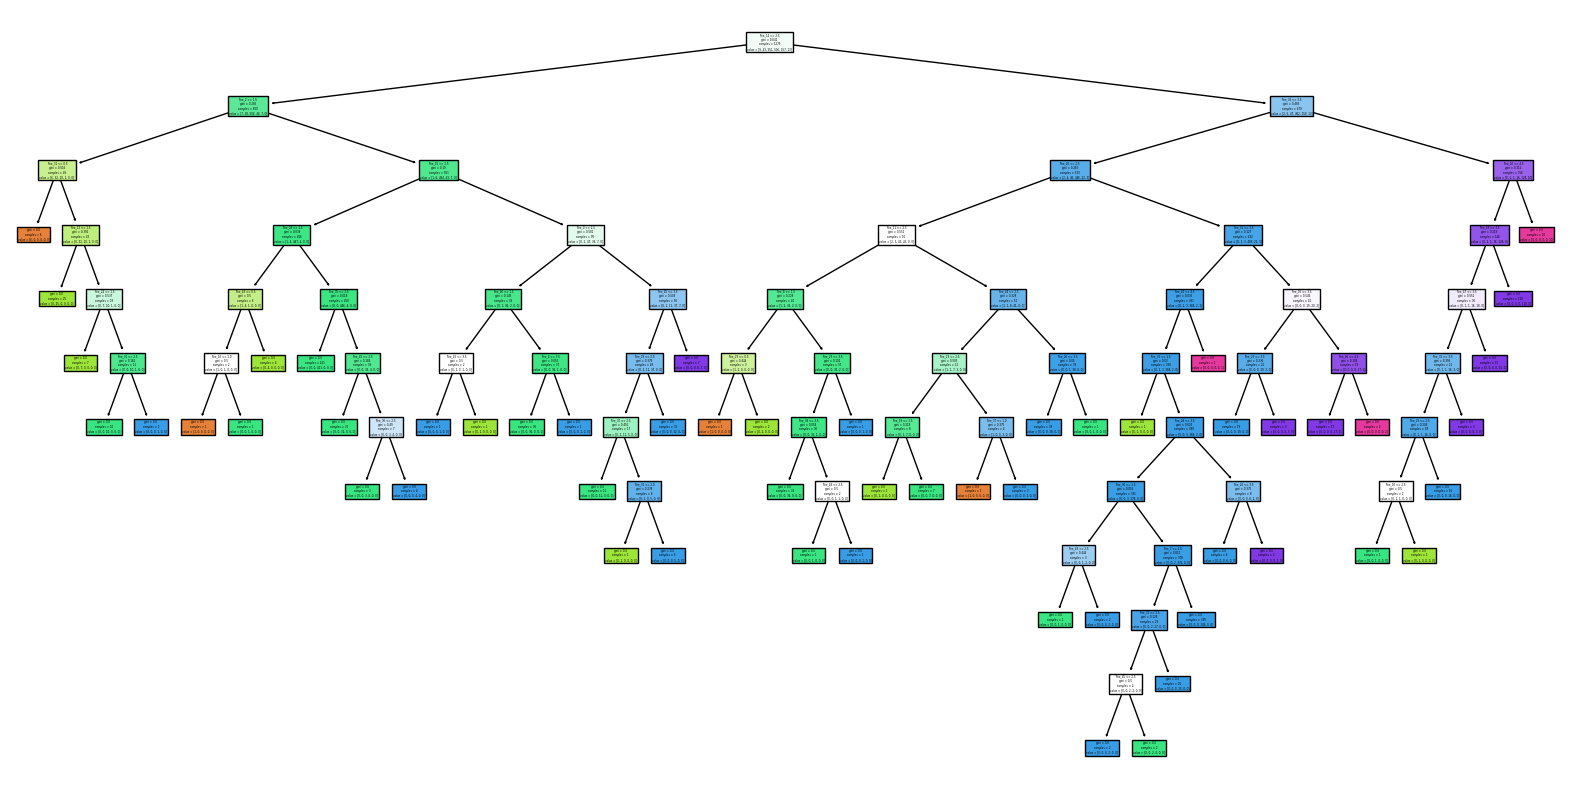

Decision Tree:
|--- Tree_14 <= 2.50
|   |--- Tree_2 <= 1.50
|   |   |--- Tree_31 <= 0.50
|   |   |   |--- class: 3
|   |   |--- Tree_31 >  0.50
|   |   |   |--- Tree_12 <= 1.50
|   |   |   |   |--- class: 4
|   |   |   |--- Tree_12 >  1.50
|   |   |   |   |--- Tree_24 <= 1.50
|   |   |   |   |   |--- class: 4
|   |   |   |   |--- Tree_24 >  1.50
|   |   |   |   |   |--- Tree_31 <= 2.50
|   |   |   |   |   |   |--- class: 5
|   |   |   |   |   |--- Tree_31 >  2.50
|   |   |   |   |   |   |--- class: 6
|   |--- Tree_2 >  1.50
|   |   |--- Tree_15 <= 2.50
|   |   |   |--- Tree_28 <= 1.50
|   |   |   |   |--- Tree_43 <= 0.50
|   |   |   |   |   |--- Tree_10 <= 1.00
|   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- Tree_10 >  1.00
|   |   |   |   |   |   |--- class: 5
|   |   |   |   |--- Tree_43 >  0.50
|   |   |   |   |   |--- class: 4
|   |   |   |--- Tree_28 >  1.50
|   |   |   |   |--- Tree_35 <= 2.50
|   |   |   |   |   |--- class: 5
|   |   |   |   |--- Tree_35 >  2.50
|

In [37]:
base_clf=DecisionTreeClassifier()

bagging_clf=BaggingClassifier(base_estimator=base_clf,n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

feature_names = df.columns[df.columns !='quality']
class_names=list(df['quality'].unique())

aggregate_predictions = np.zeros((len(X_train), len(bagging_clf.estimators_)))
for i, tree in enumerate(bagging_clf.estimators_):
    aggregate_predictions[:, i] = tree.predict(X_train)


final_tree = DecisionTreeClassifier()
final_tree.fit(aggregate_predictions, y_train)

plt.figure(figsize=(20, 10))
plot_tree(final_tree, feature_names=[f"Tree_{i}" for i in range(len(bagging_clf.estimators_))], filled=True)
plt.show()

tree_text = export_text(final_tree, feature_names=[f"Tree_{i}" for i in range(len(bagging_clf.estimators_))])
print("Decision Tree:")
print(tree_text)

In [38]:
y_pred = bagging_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy of BaggingClassifier: {accuracy:.2f}')

Accuracy of BaggingClassifier: 0.66


In [58]:
## random forest

from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.659375


In [63]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define the parameter distributions
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(range(10, 110, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_distributions=param_dist, n_iter=100, cv=5, random_state=42, scoring='accuracy', n_jobs=-1)
random_search.fit(X_train, y_train)


best_params = random_search.best_params_


In [64]:
best_params

{'max_depth': 20,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 355}

In [65]:
rf_classifier = RandomForestClassifier(**best_params)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.6625


In [67]:
from sklearn.model_selection import GridSearchCV


param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],     # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
}


rf_classifier = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)


grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [69]:
best_params

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [70]:
rf_classifier = RandomForestClassifier(**best_params,random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_rf)
print("Accuracy:", accuracy)

Accuracy: 0.659375
